# Credit Card Fraud Analysis and Detection

---

## Problem Identification

### Problem statement

How can credit card companies detect up to 90% of fraudulent transactions?

### Key data sources

- [Credit Card Fraud Detection Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud)

---

## Environment setup

In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.set('notebook')

In [2]:
# Read CSV to Dataframe
df = pd.read_csv('../data/raw/creditcard.csv')

In [3]:
# Inspect the data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve

def metrics_plots(model, X_test, y_test):
    '''Plot Recall Precision AUC'''    
    y_pred = model.predict(X_test)
    fig = plt.figure(figsize=(15,5))

    # Confusion matrix 
    ax = fig.add_subplot(121)
    labels = ['Normal', 'Fraud'] 
    conf_matrix = confusion_matrix(y_test, y_pred) 
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax); 
    plt.title("Confusion matrix") 
    plt.xlabel('True class') 
    plt.ylabel('Predicted class') 
    
    # AUC graph
    ax = fig.add_subplot(122)
    plot_precision_recall_curve(model, X_test, y_test, ax=ax)
    
    plt.show()

In [20]:
from sklearn.metrics import accuracy_score, auc, f1_score, matthews_corrcoef, precision_recall_curve, precision_score, recall_score

def metrics(model, X_test, y_test):
    '''Print out metrics'''
    # Predict
    y_pred = model.predict(X_test)    
    probabilities = model.predict_proba(X_test)[:,1]

    # Calculate AUC
    precision, recall, _ = precision_recall_curve(y_test, probabilities)
    auc_score = auc(recall, precision)
    
    print(f'Predicted labels: {(np.unique(y_pred))}')
    print(pd.DataFrame(y_pred)[0].value_counts())
    
    print(f'\nAccuracy:  {accuracy_score(y_test, y_pred):.4}')
    print(f'Recall:    {recall_score(y_test, y_pred):.4}')
    print(f'Precision: {precision_score(y_test, y_pred):.4}')
    
    # This style will make it easier to copy and paste for a Markdown table
    print(f'\nAUC    | F1 Score | MCC Score')
    print(f'{auc_score:.4} | {f1_score(y_test, y_pred):.4}   | {matthews_corrcoef(y_test, y_pred):.4}')

In [21]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, save_path='conf-matrix.png'):
    '''Plot the confusion matrix for a model'''
    y_pred = model.predict(X_test)
    
    labels = ['Normal', 'Fraud'] 
    conf_matrix = confusion_matrix(y_test, y_pred) 

    plt.figure(figsize=(5, 5)) 
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap="Blues", cbar=False); 
    plt.title("Confusion matrix") 
    plt.xlabel('True class') 
    plt.ylabel('Predicted class')
    
    plt.savefig(save_path, bbox_inches = 'tight')
    plt.show()

In [22]:
from sklearn.metrics import plot_precision_recall_curve

def plot_auc_results(models, X_test, y_test, save_path='prauc-results.png'):
    '''Plot Recall Precision AUC results'''
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    for model in models:
        plot_precision_recall_curve(model, X_test, y_test, ax=ax)
    
    plt.savefig(save_path, bbox_inches = 'tight')
    plt.show()

## RandomForestClassifier with Minority Class Upsampling

### Standard Upsampling (equal resample)

In [28]:
from sklearn.utils import resample

# Reset split
X = df.drop('Class', axis=1)
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Concatenate training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
not_fraud = X[X.Class == 0]
fraud = X[X.Class == 1]

# Upsample minority class (fraud)
fraud_upsampled = resample(fraud, replace=True, n_samples=len(not_fraud), random_state=42)

# Combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# Check new class counts
upsampled.Class.value_counts()

1    199020
0    199020
Name: Class, dtype: int64

In [29]:
# Update training
X_train = upsampled.drop('Class', axis=1)
y_train = upsampled.Class

Predicted labels: [0 1]
0    85322
1      121
Name: 0, dtype: int64

Accuracy:  0.9993
Recall:    0.7162
Precision: 0.876

AUC    | F1 Score | MCC Score
0.8024 | 0.7881   | 0.7918


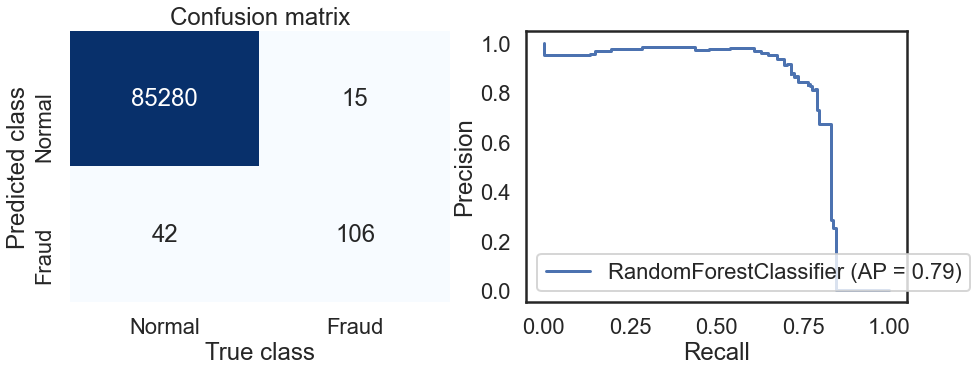

In [30]:
# Fit model
rfc_up_1 = RandomForestClassifier(max_depth=20, n_estimators=10, random_state=42).fit(X_train, y_train)

# Evaluate
metrics(rfc_up_1, X_test, y_test)
metrics_plots(rfc_up_1, X_test, y_test)

### Standard Upsampling (50% resample)

In [31]:
# Reset split
X = df.drop('Class', axis=1)
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Concatenate training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
not_fraud = X[X.Class == 0]
fraud = X[X.Class == 1]

# Upsample minority class (fraud)
fraud_upsampled = resample(fraud, replace=True, n_samples=int(len(not_fraud) / 2), random_state=42)

# Combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# Check new class counts
upsampled.Class.value_counts()

0    199020
1     99510
Name: Class, dtype: int64

In [32]:
# Update training
X_train = upsampled.drop('Class', axis=1)
y_train = upsampled.Class

Predicted labels: [0 1]
0    85328
1      115
Name: 0, dtype: int64

Accuracy:  0.9994
Recall:    0.7162
Precision: 0.9217

AUC    | F1 Score | MCC Score
0.8221 | 0.8061   | 0.8122


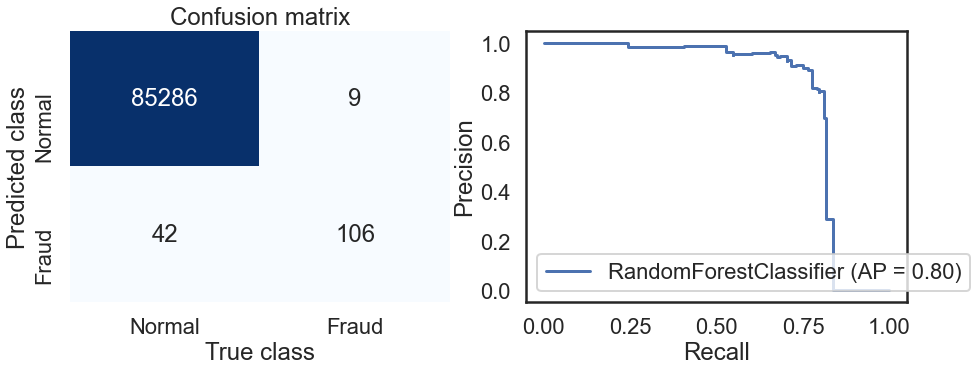

In [33]:
# Fit model
rfc_up_2 = RandomForestClassifier(max_depth=20, n_estimators=10, random_state=42).fit(X_train, y_train)

# Evaluate
metrics(rfc_up_2, X_test, y_test)
metrics_plots(rfc_up_2, X_test, y_test)

### SMOTE  Upsampling (equal resample)

In [34]:
from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1)
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

sm = SMOTE(sampling_strategy=1.0, random_state=42)

X_train, y_train = sm.fit_sample(X_train, y_train)

In [35]:
y_train.value_counts()

1    199020
0    199020
Name: Class, dtype: int64

Predicted labels: [0 1]
0    85299
1      144
Name: 0, dtype: int64

Accuracy:  0.9993
Recall:    0.777
Precision: 0.7986

AUC    | F1 Score | MCC Score
0.8216 | 0.7877   | 0.7874


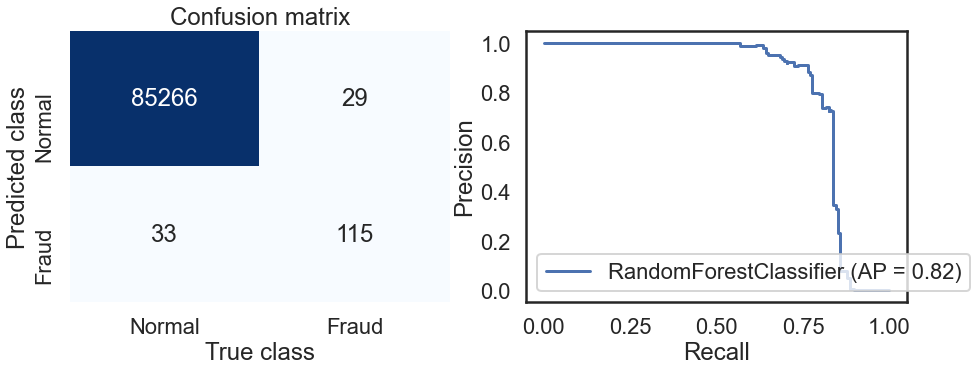

In [36]:
# Fit model
rfc_up_3 = RandomForestClassifier(max_depth=20, n_estimators=10, random_state=42).fit(X_train, y_train)

# Evaluate
metrics(rfc_up_3, X_test, y_test)
metrics_plots(rfc_up_3, X_test, y_test)

### SMOTE  Upsampling (50% resample)

In [37]:
from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1)
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

sm = SMOTE(sampling_strategy=0.5, random_state=42)

X_train, y_train = sm.fit_sample(X_train, y_train)

In [38]:
y_train.value_counts()

0    199020
1     99510
Name: Class, dtype: int64

Predicted labels: [0 1]
0    85306
1      137
Name: 0, dtype: int64

Accuracy:  0.9994
Recall:    0.7905
Precision: 0.854

AUC    | F1 Score | MCC Score
0.8094 | 0.8211   | 0.8214


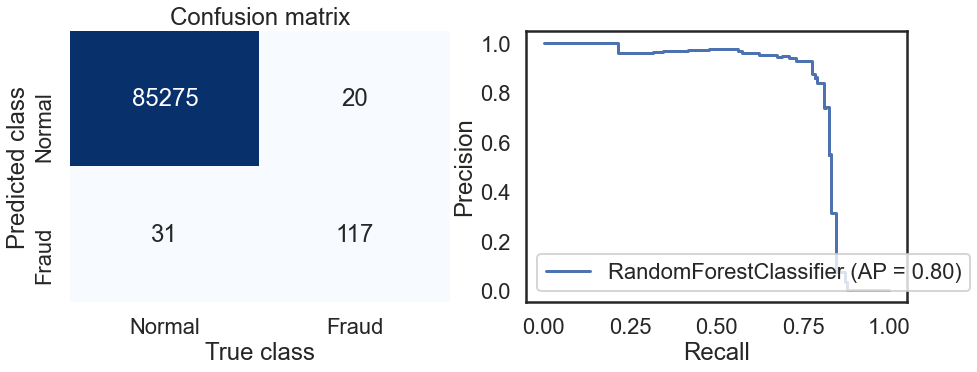

In [39]:
# Fit model
rfc_up_4 = RandomForestClassifier(max_depth=20, n_estimators=10, random_state=42).fit(X_train, y_train)

# Evaluate
metrics(rfc_up_4, X_test, y_test)
metrics_plots(rfc_up_4, X_test, y_test)

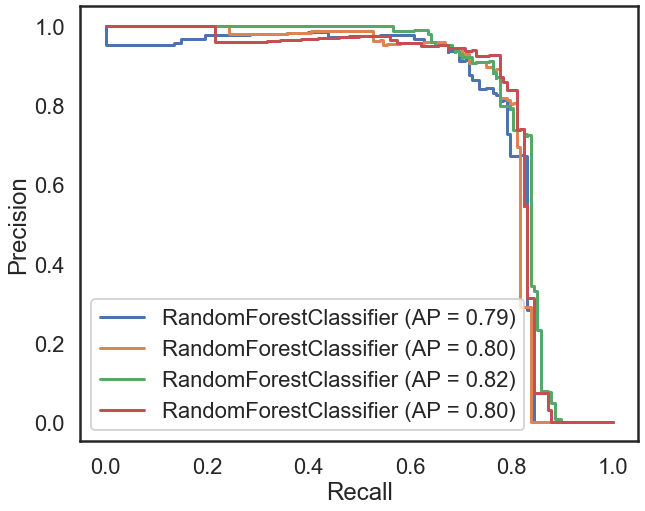

In [40]:
plot_auc_results([rfc_up_1, rfc_up_2, rfc_up_3, rfc_up_4], X_test, y_test, 'rfc-upsample-prauc.png')

### ⚠️ Upsampling is not beneficial to the best model (Random Forest Classifier).

## Hyperparameter Optimization

In [41]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [42]:
# NOTE: this takes >100 minutes to complete
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 10, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=42, 
#                                n_jobs = 2)
# rf_random.fit(X_train, y_train)

best_params = {
    'bootstrap': False,
    'max_depth': 80,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 94,
    'random_state': 42,
    'verbose': 1,
    'n_jobs': -1
}

In [43]:
# Reset split (no upsampling because it didn't help)
X = df.drop('Class', axis=1)
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  94 out of  94 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  94 out of  94 | elapsed:    0.3s finished


Predicted labels: [0 1]
0    85325
1      118
Name: 0, dtype: int64

Accuracy:  0.9995
Recall:    0.7635
Precision: 0.9576

AUC    | F1 Score | MCC Score
0.8253 | 0.8496   | 0.8549


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  94 out of  94 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  94 out of  94 | elapsed:    0.3s finished


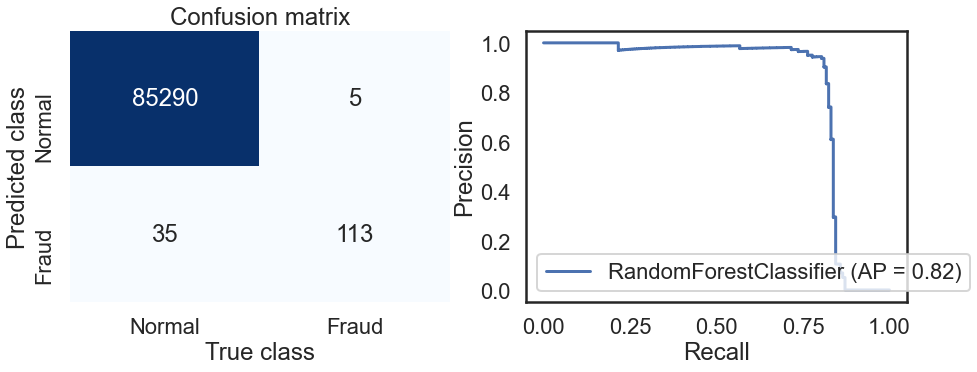

In [44]:
# Fit model
rfc_model = RandomForestClassifier(**best_params).fit(X_train, y_train)

# Evaluate
metrics(rfc_model, X_test, y_test)
metrics_plots(rfc_model, X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  94 out of  94 | elapsed:    0.3s finished


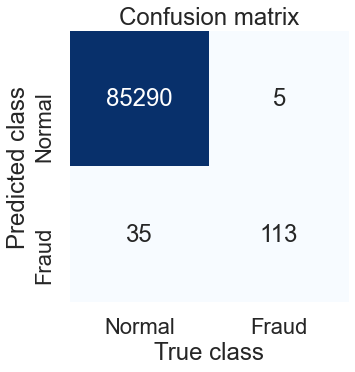

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  94 out of  94 | elapsed:    0.3s finished


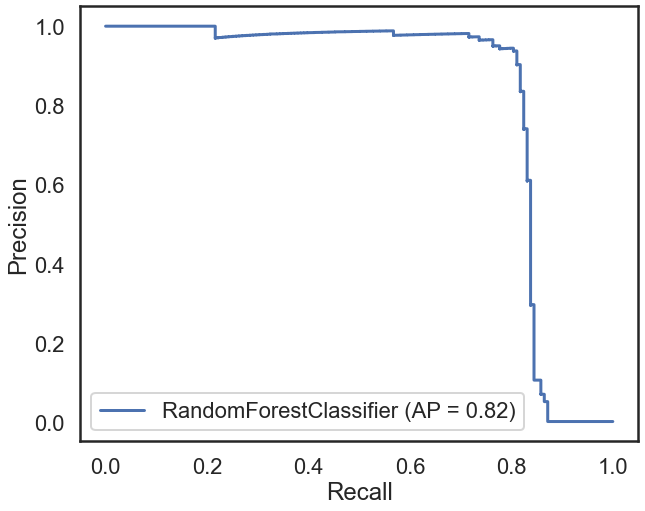

In [45]:
# Confusion Matrix and AUC plot for best model
plot_confusion_matrix(rfc_model, X_test, y_test, 'final-model-conf-matrix.png')
plot_auc_results([rfc_model], X_test, y_test, 'final-model-prauc.png')